# **DSA210 Term Project**


# **Motivation**

I enjoy MMA and wanted to explore some stats just for fun. Initially, my goal was to analyze the impact of training backgrounds (like wrestling or jiu jitsu) on fight outcomes, but due to limitations in the available data, I talked with my TA and shifted focus. Instead I examined whether physical attributes such as height, reach, and dominant win methods correlate with success in MMA. The project became a fun way to apply data science techniques to something I'm interested in.

# **Data Collection**
To construct the dataset used in this project, I implemented a custom web scraping and crawling framework for extracting MMA fighter profiles from sherdog.com and tapology.com.
The primary data collection tool was a recursive web crawler. 
It begins at a single fighter’s Sherdog profile URL and automatically traverses the network of opponents by visiting the links embedded in the fight history section.
Each individual fighter page is scraped for both summary and detailed information. 
This includes metadata (name, nationality), physical attributes (height, reach, weight, weight class) and a full professional fight history. 
Win/loss data is extracted both as summary statistics and through parsing individual fight results. 
After collection, I used additional scripts to process and flatten the nested JSON structures into tabular formats suitable for analysis. The final data was exported into CSV format.

However: **Both Tapology.com and Sherdog.com explicitly disallow web scraping and automated bots on their sites.** 
Tapology’s policies ban any data scraping or bot access​ and Sherdog’s terms similarly prohibit automated crawling beyond what a human user could do and forbid reusing scraped content, so I did **NOT** post the code I used for data collection into github. 

(I can provide it if the instructor wishes to see.)

Problems encountered during data collection: Unfortunately there is no gender information on these sites, so there was no way for me to get that data and do a gender based analysis.



## 
Some additional information about mixed martial arts terminology that might be needed to make sense of the data analysis if you are unfamiliar with them:

**Striking:** Fighting in striking arts takes place on the feet. (Strikes may include punches, kicks, elbows and knees. Emphasis is placed on accurate striking, footwork, and head movement.)


**Grappling:** Grappling is focused on what to do when the fight is taken to the ground. (Grapplers focus on closing the distance, executing a takedown, and submitting their opponent. Submissions can happen different ways such as arm bars, heel hooks, strangles, and shoulder locks.)

**KO Win:** The losing fighter is unconscious and physically unable to continue.


**Submission Win:** When a fighter decides to quit fighting, or “tap out,” the fight ends.


**Decision Win:** Both fighters will have made it through the allotted number of rounds without getting knocked out or submitting. That leaves determining the winner in the hands of the judges, who score each round based on a number of factors, including punches landed. 


# **Exploratory Data Analysis**



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde

df = pd.read_csv("data_final.csv")


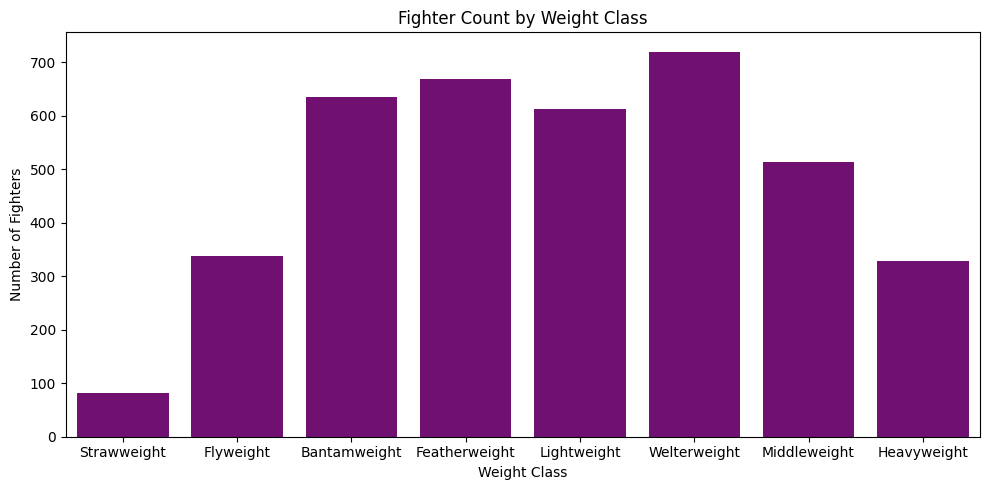

In [2]:
# ------------------
# Histogram for Fighter Count by Weight Class
# ------------------

# Ordered Weight Classes
weight_order = [
    'Strawweight',
    'Flyweight',
    'Bantamweight',
    'Featherweight',
    'Lightweight',
    'Welterweight',
    'Middleweight',
    'Heavyweight'
]

weight_counts = df['primary_division'].value_counts()
weight_counts = weight_counts.reindex(weight_order)

# Histogram
plt.figure(figsize=(10, 5))
sns.barplot(x=weight_counts.index, y=weight_counts.values, color="purple")
plt.title("Fighter Count by Weight Class")
plt.xlabel("Weight Class")
plt.ylabel("Number of Fighters")
plt.tight_layout()
plt.show()

The bar chart displaying the number of fighters in each weight class reveals an imbalance across divisions.
The data reveals that the majority of fighters are concentrated in the Bantamweight, Featherweight, Lightweight, and Welterweight divisions. These divisions have the highest number of entries, reflecting both the most competitive and most populated ranges for professional athletes in MMA.

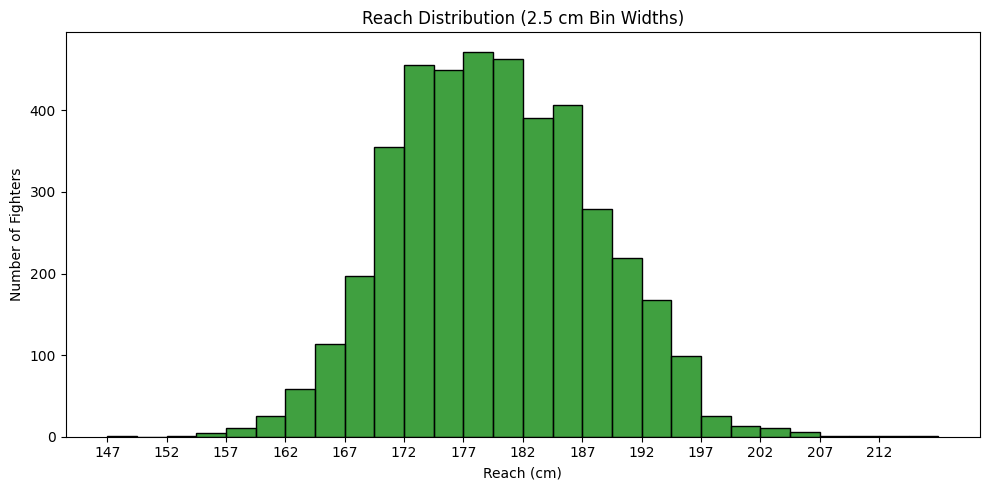

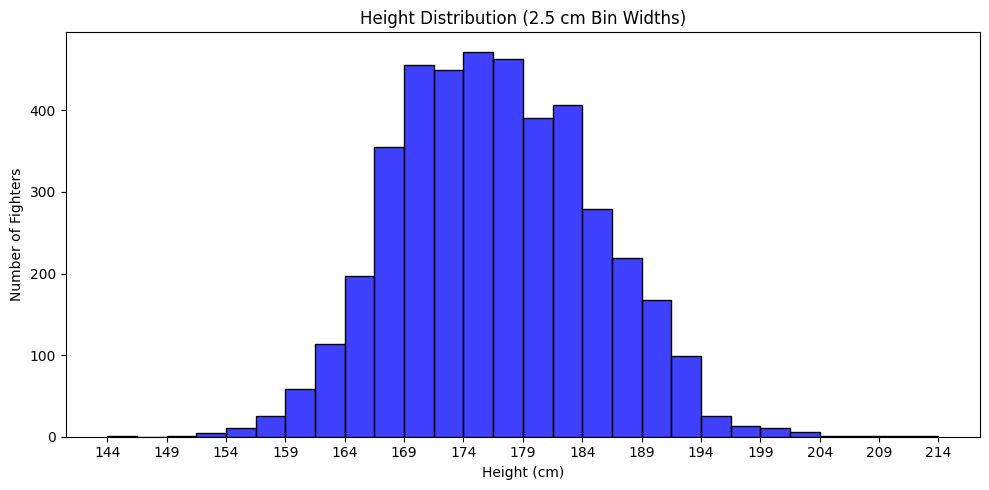

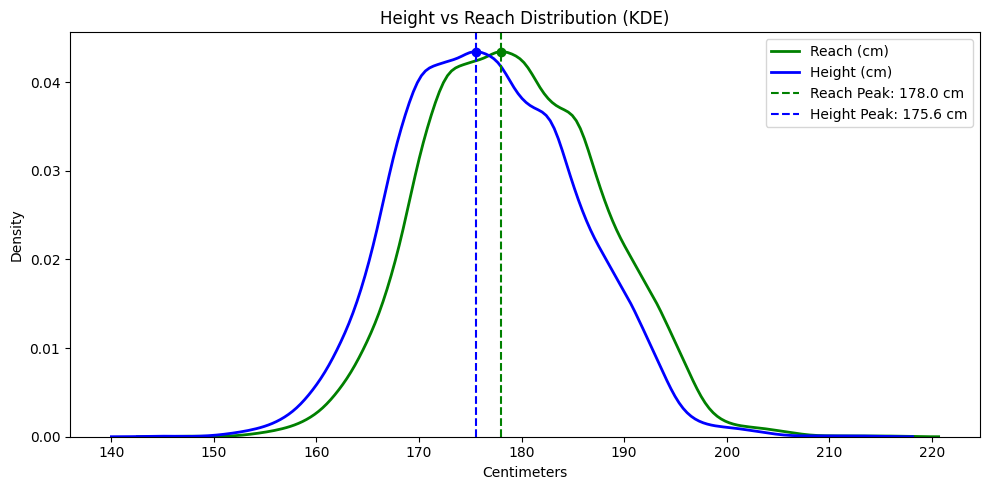

In [3]:
# ------------------
# Histogram for Reach
# ------------------

min_reach = np.floor(df['reach'].min())
max_reach = np.ceil(df['reach'].max())
bins_reach = np.arange(min_reach, max_reach + 2.5, 2.5)

plt.figure(figsize=(10, 5))
sns.histplot(df['reach'], bins=bins_reach, color='green', edgecolor='black')
plt.title("Reach Distribution (2.5 cm Bin Widths)")
plt.xlabel("Reach (cm)")
plt.ylabel("Number of Fighters")
plt.xticks(np.arange(min_reach, max_reach + 1, 5))
plt.tight_layout()
plt.show()

# ------------------
# Histogram for Height
# ------------------

min_height = np.floor(df['height'].min())
max_height = np.ceil(df['height'].max())
bins_height = np.arange(min_height, max_height + 2.5, 2.5)

plt.figure(figsize=(10, 5))
sns.histplot(df['height'], bins=bins_height, color='blue', edgecolor='black')
plt.title("Height Distribution (2.5 cm Bin Widths)")
plt.xlabel("Height (cm)")
plt.ylabel("Number of Fighters")
plt.xticks(np.arange(min_height, max_height + 1, 5))
plt.tight_layout()
plt.show()

# ------------------
# Combined KDE Plot: Height vs Reach
# ------------------

reach_kde = gaussian_kde(df['reach'])
height_kde = gaussian_kde(df['height'])

# Create a shared x-axis for evaluation
x = np.linspace(140, 220, 1000)
reach_vals = reach_kde(x)
height_vals = height_kde(x)

# Find peak positions
reach_peak_x = x[np.argmax(reach_vals)]
reach_peak_y = np.max(reach_vals)

height_peak_x = x[np.argmax(height_vals)]
height_peak_y = np.max(height_vals)

# Plotting
plt.figure(figsize=(10, 5))
sns.kdeplot(df['reach'], label='Reach (cm)', color='green', linewidth=2)
sns.kdeplot(df['height'], label='Height (cm)', color='blue', linewidth=2)

# Add vertical lines at peaks
plt.axvline(reach_peak_x, color='green', linestyle='--', label=f'Reach Peak: {reach_peak_x:.1f} cm')
plt.axvline(height_peak_x, color='blue', linestyle='--', label=f'Height Peak: {height_peak_x:.1f} cm')

# Mark peaks with dots
plt.scatter([reach_peak_x], [reach_peak_y], color='green', zorder=5)
plt.scatter([height_peak_x], [height_peak_y], color='blue', zorder=5)

plt.title("Height vs Reach Distribution (KDE)")
plt.xlabel("Centimeters")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()



Reach: Measured from fingertip to fingertip when your arms are held parallel to the ground. 

The reach and height distribution of fighters in the dataset displays a symmetrical bell shaped curve, suggesting that they are approximately normally distributed. This indicates that most MMA fighters share a common profile in terms of arm length and height. There are no significant spikes or gaps in the distribution. The reach curve shows a slightly broader peak and a more gradual tapering, suggesting marginally greater variability in reach than in height, but the difference is minimal (2.4 cm) 
The overlap also reinforces that there are no extreme disparities between these two traits.

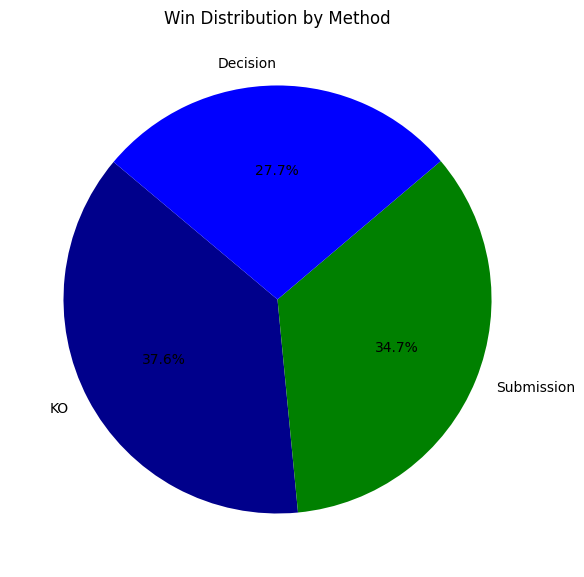

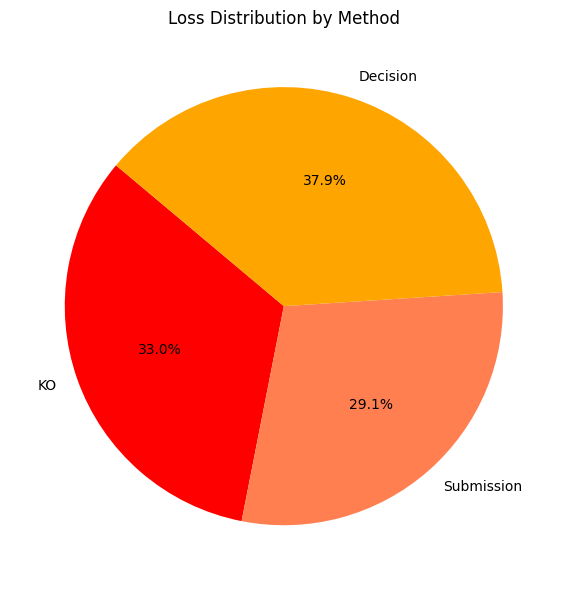

In [4]:
# -------------------------------
# Win Method Percentages
# -------------------------------


win_methods ={
    'KO': 'record_summary_wins_knockouts',
    'Submission': 'record_summary_wins_submissions',
    'Decision': 'record_summary_wins_decisions'
}

total_wins = {method: df[col].sum() for method, col in win_methods.items()}

# Pie Chart for Wins
plt.figure(figsize=(6, 6))
plt.pie(total_wins.values(), labels=total_wins.keys(), autopct='%1.1f%%', startangle=140, colors=["darkblue", "green", "blue"])
plt.title("Win Distribution by Method")
plt.tight_layout()
plt.show()

# -------------------------------
# Loss Method Percentages
# -------------------------------

loss_methods = {
    'KO': 'record_summary_losses_knockouts',
    'Submission': 'record_summary_losses_submissions',
    'Decision': 'record_summary_losses_decisions'
}

total_losses = {method: df[col].sum() for method, col in loss_methods.items()}

# Pie Chart for Losses
plt.figure(figsize=(6, 6))
plt.pie(total_losses.values(), labels=total_losses.keys(), autopct='%1.1f%%', startangle=140, colors=["red", "coral", "orange"])
plt.title("Loss Distribution by Method")
plt.tight_layout()
plt.show()


Decision losses are the most common loss type whereas it has the lowest distribution in wins. This reveales that while fighters secure wins through finishes, they more frequently lose via decision. 

This could reflect that fighters take fewer risks as they lose control of a round, leading to more fights going the distance. It might also reflect that many losing fighters are still able to defend themselves effectively enough to avoid being stopped.

Another important factor might be the limitations of my dataset. Since I was only able to collect data on a subset of MMA fighters specifically those with more complete and accessible records it’s possible that I'm unintentionally excluding fighters who lose early in their careers and then stop competing. For instance, a fighter who loses their debut by KO and never returns to the sport would contribute to someone else's win record but may not appear in my dataset at all if they didn't have a consistent record on Sherdog.

This kind of dropout bias could lead to an underrepresentation of certain types of losses because the losing side of that outcome disappears from the data. As a result, the proportion of decision losses may appear inflated simply because those fighters are more likely to have longer careers and more complete data histories. So the mismatch between win and loss distributions might not only reflect fight dynamics but also be shaped by gaps in data.

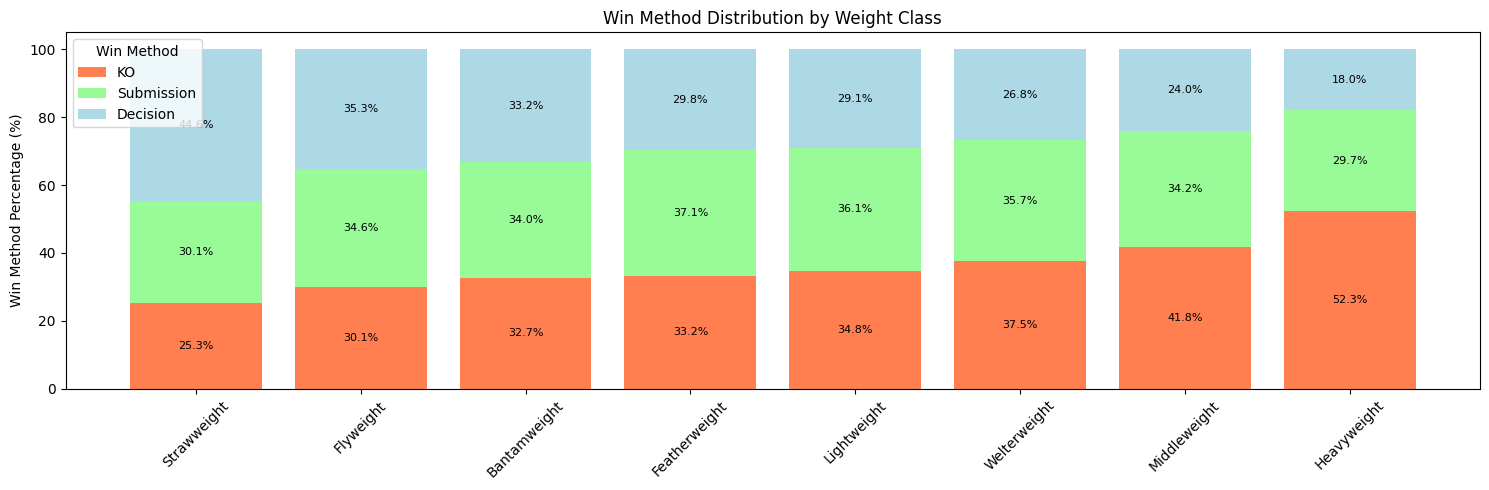

In [5]:
# -------------------------------
# Stacked Bar Chart for Win Methods by Weight Class
# -------------------------------

weight_order = [
    'Strawweight',
    'Flyweight',
    'Bantamweight',
    'Featherweight',
    'Lightweight',
    'Welterweight',
    'Middleweight',
    'Heavyweight'
]

win_methods = {
    'KO': 'record_summary_wins_knockouts',
    'Submission': 'record_summary_wins_submissions',
    'Decision': 'record_summary_wins_decisions'
}

# Group data
method_cols = list(win_methods.values())
df_filtered = df[df['primary_division'].isin(weight_order)].dropna(subset=method_cols)
grouped = df_filtered.groupby('primary_division')[method_cols].mean()
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100
grouped_percent = grouped_percent.reindex(weight_order)

# Plot
plt.figure(figsize=(15, 5))
bar1 = plt.bar(grouped_percent.index, grouped_percent[win_methods['KO']], label='KO', color="coral")
bar2 = plt.bar(grouped_percent.index, grouped_percent[win_methods['Submission']],
               bottom=grouped_percent[win_methods['KO']], label='Submission', color="palegreen")
bottom2 = grouped_percent[win_methods['KO']] + grouped_percent[win_methods['Submission']]
bar3 = plt.bar(grouped_percent.index, grouped_percent[win_methods['Decision']],
               bottom=bottom2, label='Decision', color="lightblue")

# Add percentage labels
for i, weight_class in enumerate(grouped_percent.index):
    ko = grouped_percent.loc[weight_class, win_methods['KO']]
    sub = grouped_percent.loc[weight_class, win_methods['Submission']]
    dec = grouped_percent.loc[weight_class, win_methods['Decision']]
    
    plt.text(i, ko / 2, f"{ko:.1f}%", ha='center', va='center', fontsize=8)
    plt.text(i, ko + sub / 2, f"{sub:.1f}%", ha='center', va='center', fontsize=8)
    plt.text(i, ko + sub + dec / 2, f"{dec:.1f}%", ha='center', va='center', fontsize=8)

# Formatting
plt.xticks(rotation=45)
plt.ylabel("Win Method Percentage (%)")
plt.title("Win Method Distribution by Weight Class")
plt.legend(title="Win Method")
plt.tight_layout()
plt.show()


The distribution of win types illustrates a strong relationship between body size and fight outcomes: lighter fighters are more likely to win by decision or submission, while heavier fighters overwhelmingly favor knockouts.

In the lighter divisions decisions account for a large portion of wins as these fighters tend to rely more on speed, cardio and volume striking, which often leads to longer, closely contested fights that go to the judges.

Submission wins remain relatively stable across divisions, ranging between 30% and 37%. This suggests that grappling effectiveness is somewhat consistent, though it may begin to diminish slightly in higher weight classes.

While KO wins make up only a quarter of victories at Strawweight, they rise steadily through the classes and dominate in Heavyweight. This aligns with the advantage heavier fighters have in power striking, as well as the tendency for fights in these divisions to end suddenly rather than accumulate points over rounds. Also the number of female fighters decrease in the heavier weight classes, so this might be also be an explanation.

Decision wins show the reverse trend. This indicates that the likelihood of a fight going the distance sharply decreases with size, supporting the idea that larger fighters have both more power to finish fights and potentially less cardio capacity to sustain prolonged rounds.


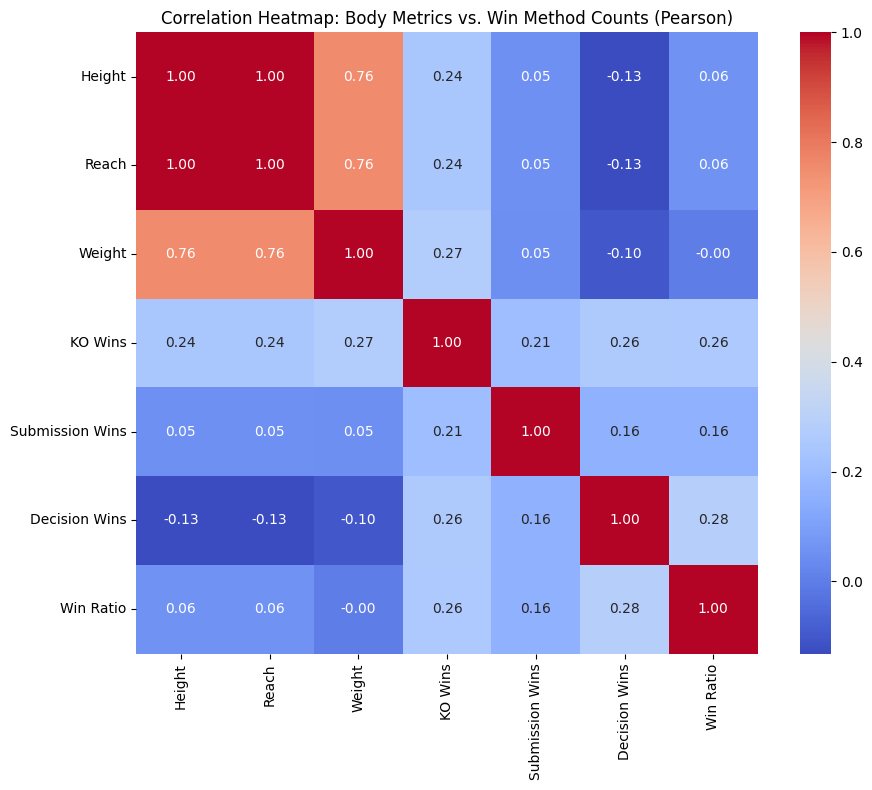

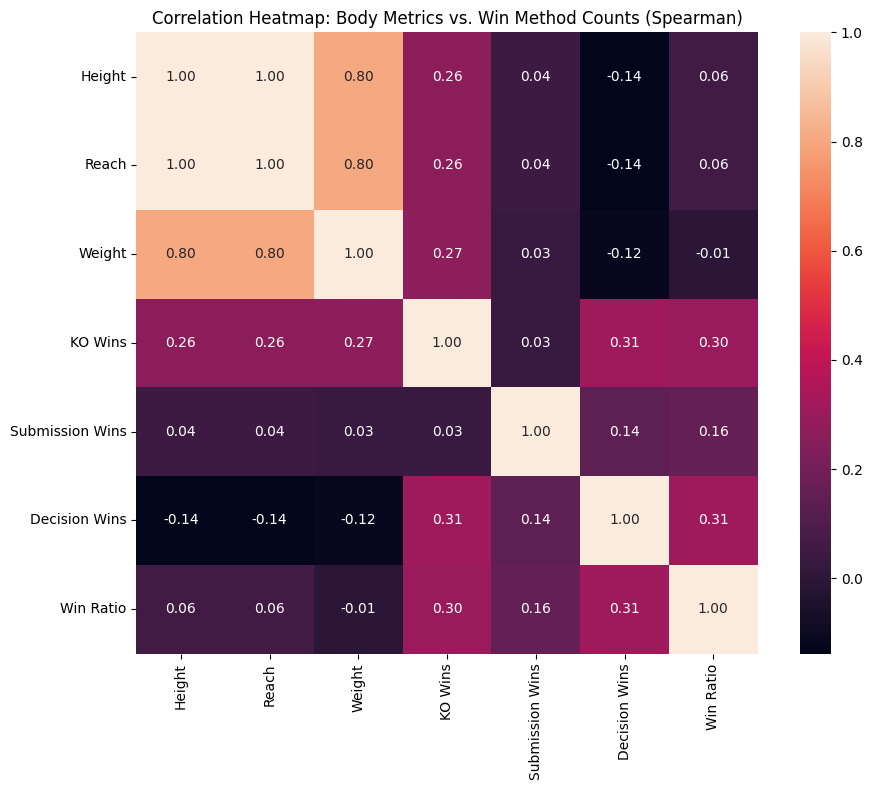

In [6]:
# -------------------------------
# Heatmaps
# -------------------------------


correlation_columns = [
    'height',
    'reach',
    'weight',
    'record_summary_wins_knockouts',
    'record_summary_wins_submissions',
    'record_summary_wins_decisions',
    'record_summary_win_ratio'
]

# Compute correlation matrix
corr_matrix = df[correlation_columns].corr()
corr_matrix2 = df[correlation_columns].corr(method="spearman")


# Dictionary for renaming labels
rename_labels = {
    'height': 'Height',
    'reach': 'Reach',
    'weight': 'Weight',
    'record_summary_wins_knockouts': 'KO Wins',
    'record_summary_wins_submissions': 'Submission Wins',
    'record_summary_wins_decisions': 'Decision Wins',
    'record_summary_win_ratio': 'Win Ratio'
}
corr_matrix.rename(index=rename_labels, columns=rename_labels, inplace=True)
corr_matrix2.rename(index=rename_labels, columns=rename_labels, inplace=True)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, fmt=".2f")
plt.title("Correlation Heatmap: Body Metrics vs. Win Method Counts (Pearson)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix2, annot=True, square=True, fmt=".2f")
plt.title("Correlation Heatmap: Body Metrics vs. Win Method Counts (Spearman)")
plt.tight_layout()
plt.show()


Initially I used Pearson correlation to explore the relationships between fighters physical attributes and their fight outcomes. The results showed weak correlations between most variables. Since Pearson correlation measures only linear relationships and is sensitive to outliers and scale, I suspected it might be underestimating the strength of certain associations, especially if the data followed a non linear pattern instead.

To investigate this further, I applied Spearman correlation which ranks values and captures monotonic relationships rather than strictly linear ones. However after generating the Spearman heatmap I found that the results did not differ substantially from Pearson. Overall patterns and magnitudes of correlation remained largely the same.

This similarity suggests that the underlying relationships between body metrics and win methods are genuinely weak in this dataset, rather than being distorted by outliers or scale effects.

(HOWEVER:
The heatmaps show that across the full population, weight and KO wins are only weakly related in a individual sense. 

But, the Chi square test I did for my hypothesis shows that the proportion of fighters who rely on KOs, submissions, or decisions does vary significantly across weight classes. So while weight doesn’t linearly predict KO count per fighter, fighting style distributions do differ by division, which is a broader categorical trend rather than an individual level prediction.)

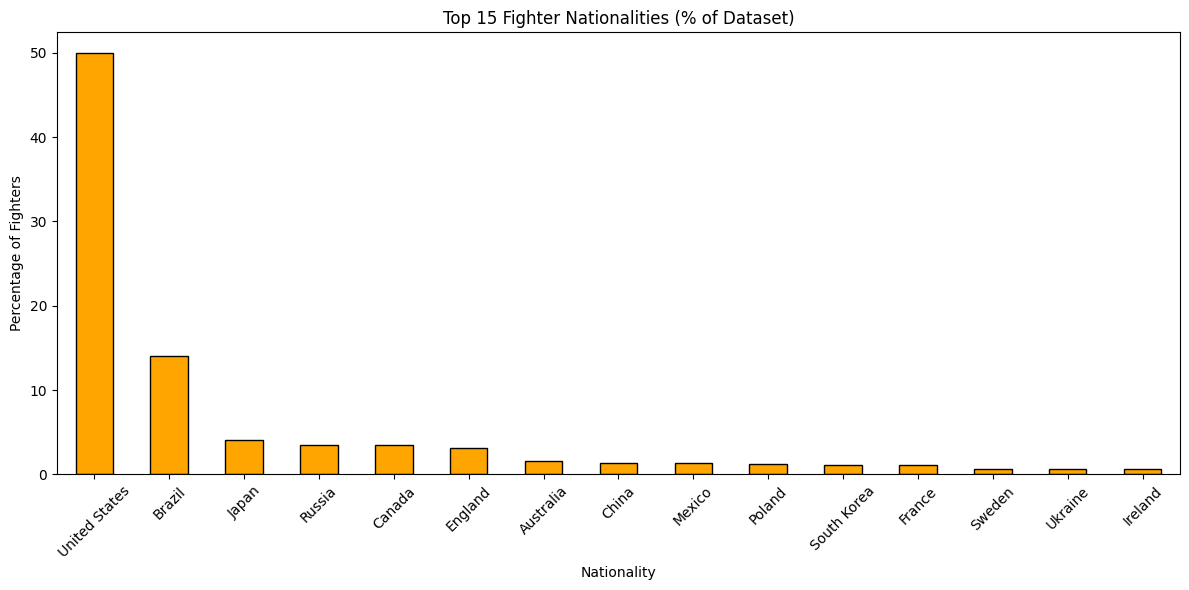

In [7]:
# -------------------------------
# Top Nationalities Chart
# -------------------------------


top_nationalities = df['basic_info_nationality'].value_counts(normalize=True).head(15) * 100

# Plot
plt.figure(figsize=(12, 6))
top_nationalities.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Top 15 Fighter Nationalities (% of Dataset)")
plt.ylabel("Percentage of Fighters")
plt.xlabel("Nationality")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The nationality distribution plot shows a highly skewed dataset. Nearly half of all fighters are from the United States. This imbalance means that any comparison by nationality would be statistically unreliable without normalizing it.

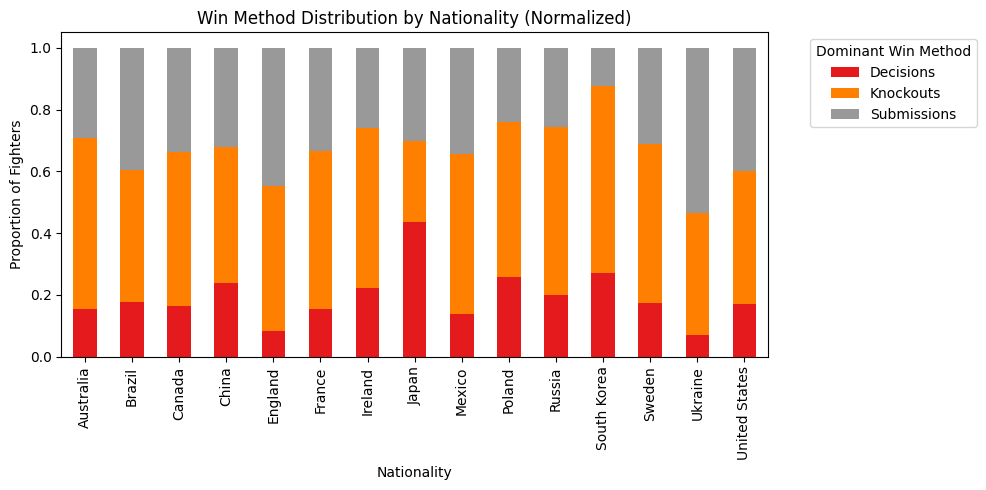

In [8]:
# -------------------------------
# Normalized Nationalities vs Win Methods Stacked Chart
# -------------------------------


# Determine dominant win method
df['dominant_win_method'] = df[['record_summary_wins_knockouts', 'record_summary_wins_submissions', 'record_summary_wins_decisions']].idxmax(axis=1)
df['dominant_win_method'] = df['dominant_win_method'].str.replace('record_summary_wins_', '').str.capitalize()

# Select top 15 nationalities by fighter count
top_nations = df['basic_info_nationality'].value_counts().head(15).index
df_top = df[df['basic_info_nationality'].isin(top_nations)]


# Plot
crosstab = pd.crosstab(df_top['basic_info_nationality'], df_top['dominant_win_method'])
crosstab_normalized = crosstab.div(crosstab.sum(axis=1), axis=0)
crosstab_normalized.plot(kind='bar', stacked=True, figsize=(10, 5), colormap='Set1')
plt.title("Win Method Distribution by Nationality (Normalized)")
plt.xlabel("Nationality")
plt.ylabel("Proportion of Fighters")
plt.legend(title="Dominant Win Method", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


This visualization gives us a normalized comparison of win method preferences across the top 15 nationalities in the dataset accounting for population imbalance.

Japan has a very high proportions of fighters who predominantly win by decision suggesting a pattern of fighting that leads to going the distance. 

In contrast, Brazil and Russia show a strong tilt toward submissions which aligns with Brazil’s jiu jitsu and Russia’s sambo background. (Both are grappling heavy fighting styles)

# **Hypothesis Testing**


## **Hypothesis 1**

**Null Hypothesis:** Fighter weight class is independent of dominant win method. (No relationship between weight class and preferred win method.)

**Alternative Hypothesis:** Fighter weight class is associated with dominant win method. (Certain weight classes favor certain win methods.)

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency


df = pd.read_csv("data_final.csv")

Chi-Square Test:
Chi2 statistic: 257.478845398615
p-value: 1.5094133763865728e-45
Degrees of freedom: 16


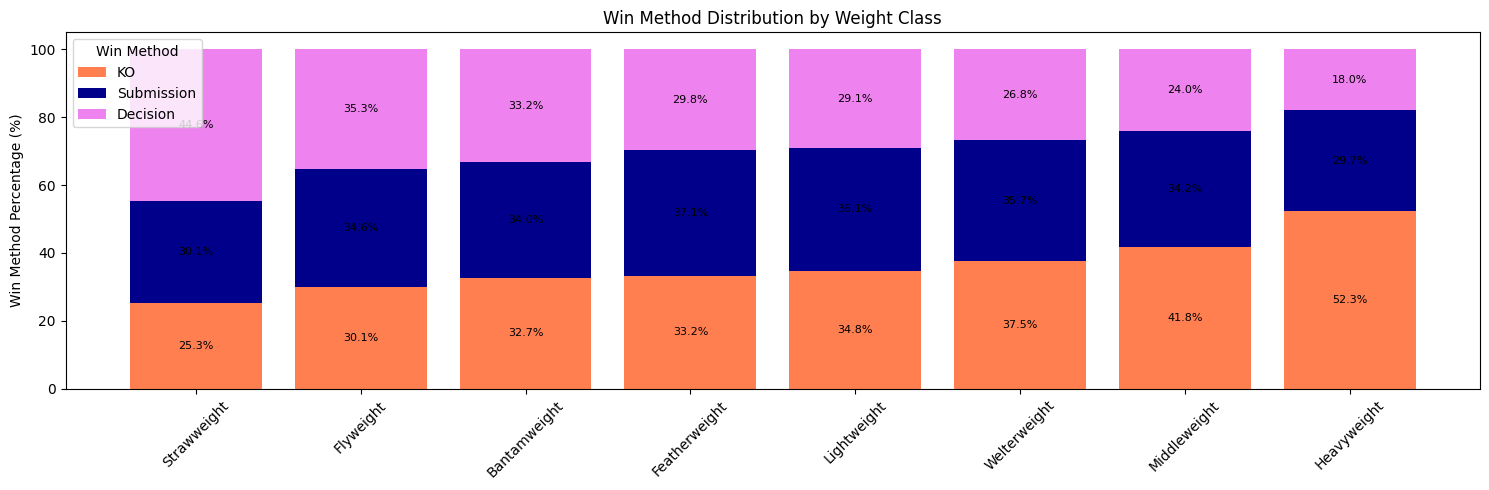

In [10]:
# Define dominant win method
df['dominant_win_method'] = df[
    ['record_summary_wins_knockouts', 'record_summary_wins_submissions', 'record_summary_wins_decisions']
].idxmax(axis=1).str.replace('record_summary_wins_', '').str.capitalize()

# Create contingency table
contingency = pd.crosstab(df['primary_division'], df['dominant_win_method'])

# Run Chis quare test
chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-Square Test:")
print("Chi2 statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)

weight_order = [
    'Strawweight',
    'Flyweight',
    'Bantamweight',
    'Featherweight',
    'Lightweight',
    'Welterweight',
    'Middleweight',
    'Heavyweight'
]

win_methods = {
    'KO': 'record_summary_wins_knockouts',
    'Submission': 'record_summary_wins_submissions',
    'Decision': 'record_summary_wins_decisions'
}

# Group data
method_cols = list(win_methods.values())
df_filtered = df[df['primary_division'].isin(weight_order)].dropna(subset=method_cols)
grouped = df_filtered.groupby('primary_division')[method_cols].mean()
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100
grouped_percent = grouped_percent.reindex(weight_order)

# Plot
plt.figure(figsize=(15, 5))
bar1 = plt.bar(grouped_percent.index, grouped_percent[win_methods['KO']], label='KO', color="coral")
bar2 = plt.bar(grouped_percent.index, grouped_percent[win_methods['Submission']],
               bottom=grouped_percent[win_methods['KO']], label='Submission', color="darkblue")
bottom2 = grouped_percent[win_methods['KO']] + grouped_percent[win_methods['Submission']]
bar3 = plt.bar(grouped_percent.index, grouped_percent[win_methods['Decision']],
               bottom=bottom2, label='Decision', color="violet")

# Add percentage labels
for i, weight_class in enumerate(grouped_percent.index):
    ko = grouped_percent.loc[weight_class, win_methods['KO']]
    sub = grouped_percent.loc[weight_class, win_methods['Submission']]
    dec = grouped_percent.loc[weight_class, win_methods['Decision']]
    
    plt.text(i, ko / 2, f"{ko:.1f}%", ha='center', va='center', fontsize=8)
    plt.text(i, ko + sub / 2, f"{sub:.1f}%", ha='center', va='center', fontsize=8)
    plt.text(i, ko + sub + dec / 2, f"{dec:.1f}%", ha='center', va='center', fontsize=8)

# Formatting
plt.xticks(rotation=45)
plt.ylabel("Win Method Percentage (%)")
plt.title("Win Method Distribution by Weight Class")
plt.legend(title="Win Method")
plt.tight_layout()
plt.show()



I first identified each fighter’s dominant win method by selecting the win type they achieved most frequently. I then grouped fighters by their primary weight class and constructed a contingency table comparing weight class to dominant win method. Using a Chi Square Test of Independence, I evaluated whether there was a significant association between these two categorical variables.

The results were:

1. Chi-square statistic: 257.48
2. Degrees of freedom: 16
3. p-value: 1.51 × 10⁻⁴⁵

**Given the small p-value, I rejected the null hypothesis.**

Given the extremely small p-value, I rejected the null hypothesis.
Certain weight classes tend to favor certain types of victories.

## **Hypothesis 2**
**Null Hypothesis:** Tall and short fighters are equally likely to favor KOs.

**Alternative Hypothesis:** Taller fighters are more likely to have knockouts as their dominant win method.

T-test result:
t-statistic: 12.81804486683294
p-value: 2.017729723031059e-36


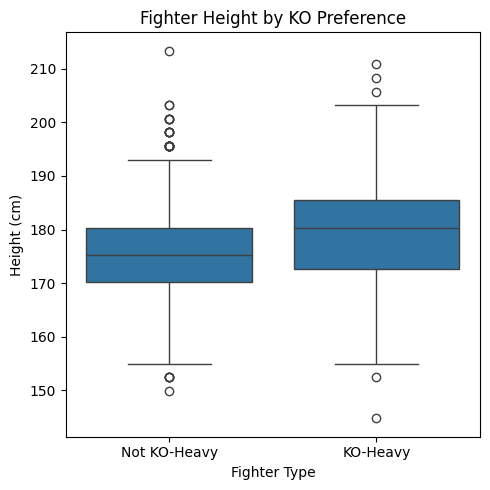

In [11]:
# Calculate KO win % and classify KO-heavy fighters
df_clean = df.dropna(subset=['height', 'record_summary_wins_knockouts', 'record_summary_wins_total', 'record_summary_win_ratio'])
df_clean = df_clean[df_clean['record_summary_wins_total'] > 0]
df_clean['ko_win_pct'] = df_clean['record_summary_wins_knockouts'] / df_clean['record_summary_wins_total']
df_clean['is_ko_heavy'] = df_clean['ko_win_pct'] >= 0.5

# Create two groups by KO preference
group_ko = df_clean[df_clean['is_ko_heavy']]['height']
group_other = df_clean[~df_clean['is_ko_heavy']]['height']

# T-test for height difference
t_stat, p_val = ttest_ind(group_ko, group_other, equal_var=False)
print("T-test result:")
print("t-statistic:", t_stat)
print("p-value:", p_val)

# Plot
plt.figure(figsize=(5, 5))
sns.boxplot(data=df_clean, x='is_ko_heavy', y='height')
plt.xticks([0, 1], ['Not KO-Heavy', 'KO-Heavy'])
plt.title("Fighter Height by KO Preference")
plt.xlabel("Fighter Type")
plt.ylabel("Height (cm)")
plt.tight_layout()
plt.show()


I tested the hypothesis, "Tall and short fighters are equally likely to favor KOs." using a two-sample t-test. 
Fighters were grouped based on whether knockouts constituted at least 50% of their wins (KO-heavy group) or not (non-KO-heavy group).

The results were:
1. t-statistic = 12.82
1. p-value = 2 × 10⁻³⁶

**Since the p value is below 0.05, I reject the null hypothesis.**

The boxplot visually supports this conclusion: KO-heavy fighters show a higher median height.